# **Lab 5: Wide and Deep Networks**
**Name(s):** Luke Voinov, Tiffany Nguyen, Emmanuel Garcia, Nimai Keshu

We use the Book Recommendation dataset:

https://www.kaggle.com/datasets/oscarm524/book-recommendation?select=items.csv

This dataset will take as input details about transactions for a specific book. Given the details about how a specific user interacts with a book, and given a model that has learned the relationship between each book, this system will recommend the user interacting with the book other books. 

Much of the code in this dataset was adapted from Eric Larson, MachineLearningNotebooks/10a. Keras Wide and Deep as TFData.ipynb:

https://github.com/eclarson/MachineLearningNotebooks/blob/4c21e29effcd7d7b9ba7f06a841d91d23cc11319/10a.%20Keras%20Wide%20and%20Deep%20as%20TFData.ipynb

We will denote this reference with (1)


In [2]:
# Import any dependencies

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

## **1. Pre-processing**

### **1.1 Preparation**

Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used (include a description of any newly formed variables you created). It is preferred to use tf.dataset and Keras Feature spaces for pre-processing, but it is not required.*

First, we have to clean and merge some datasets

In [3]:
# Code adapted from Github Copilot to work with pipe delimiters and other csv issues

path1 = "items.csv"
path2 = "transactions.csv"

# read the items.csv (book information) into df1
df1 = pd.read_csv(path1, sep='|', usecols=range(6), 
                  names=['itemID', 'title', 'author', 'publisher', 'main_topic', 'subtopics'],
                  skiprows=1, encoding='utf-8', quoting=3) 

# Read the transaction information into df2
df2 = pd.read_csv(path2, sep='|', usecols=range(5),
                  names=['customer', 'itemID', 'click', 'basket', 'order'], # rename sessionID to custmer for mor clarity
                  skiprows=1, encoding='utf-8')

# General infomation about df1
print("Items DataFrame:")
print(df1.head())
print(f"\nItems shape: {df1.shape}")
print(f"Items columns: {df1.columns.tolist()}")
print(f"Items dtypes:\n{df1.dtypes}")

FileNotFoundError: [Errno 2] No such file or directory: 'items.csv'

In [35]:
# General information about df2

print("Transactions DataFrame:")
print(df2.head())
print(f"\nTransactions shape: {df2.shape}")
print(f"Transactions columns: {df2.columns.tolist()}")

Transactions DataFrame:
   customer  itemID  click  basket  order
0         0   21310      1       0      0
1         1   73018      1       0      0
2         2   19194      1       0      0
3         3   40250      1       0      0
4         4   46107      1       0      0

Transactions shape: (365143, 5)
Transactions columns: ['customer', 'itemID', 'click', 'basket', 'order']


In [36]:
# Code from Github Copilot was adapted to merge and clean the dataset
# Merge the two DataFrames on 'itemID'

# Clean itemID: remove any quotes and convert to int in both DataFrames
df1['itemID'] = df1['itemID'].astype(str).str.replace('"', '', regex=False).str.strip().astype(int)
df2['itemID'] = df2['itemID'].astype(str).str.replace('"', '', regex=False).str.strip().astype(int)

df = pd.merge(df2, df1, on='itemID', how='inner') # each transaction associated with a book id was matched with the book id and its information

print(f"Merged DataFrame shape: {df.shape}")
print(f"Merged columns: {df.columns.tolist()}")
df.head(10)

Merged DataFrame shape: (365143, 10)
Merged columns: ['customer', 'itemID', 'click', 'basket', 'order', 'title', 'author', 'publisher', 'main_topic', 'subtopics']


,customer,itemID,click,basket,order,title,author,publisher,main_topic,subtopics
0,0,21310,1,0,0,Princess Poppy: The Big Mix Up,Janey Louise Jones,Penguin Random House Children's UK,YFB,[5AH]
1,1,73018,1,0,0,Einfach zeichnen! Step by Step,Wiebke Krabbe,Schwager und Steinlein,AGZ,"[5AJ,AGZ,WFA,YBG,YBL,YNA,YPA]"
2,2,19194,1,0,0,Red Queen 1,Victoria Aveyard,Orion Publishing Group,YFH,"[5AP,FBA]"
3,3,40250,1,0,0,Meine Kindergarten-Freunde (Pirat),NaN,Ars Edition GmbH,YB,"[5AC,5AD,YBG,YBL,YF]"
4,4,46107,1,0,0,Mein großes Schablonen-Buch - Wilde Tiere,Elizabeth Golding,Edition Michael Fischer,WFTM,"[WD,WFTM,YBG,YBL,YBLD,YBLN1]"
5,5,34217,1,0,0,Ewig geliebt,J. R. Ward,Heyne Taschenbuch,FMR,"[1KBB-US-NAK,FMX,FRX,3MRBF]"
6,6,31436,1,0,0,Meine Sticker-Tiere,NaN,Ars Edition GmbH,YBG,"[5AD,YBG,YBLL]"
7,7,14576,1,1,0,Unsterblich 01 - Tor der Dämmerung,Julie Kagawa,Heyne Taschenbuch,YFE,"[5AQ,FM,YFE,YFH]"
8,7,17731,2,1,0,Unsterblich 02 - Tor der Nacht,Julie Kagawa,Heyne Taschenbuch,YFH,"[5AQ,FM,YFE,YFH]"
9,8,58723,1,0,0,Pedro und die Bettler von Cartagena,Ursula Hasler,dtv Verlagsgesellschaft,YFB,"[5AM,1KLSC]"


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365143 entries, 0 to 365142
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   customer    365143 non-null  int64 
 1   itemID      365143 non-null  int32 
 2   click       365143 non-null  int64 
 3   basket      365143 non-null  int64 
 4   order       365143 non-null  int64 
 5   title       365143 non-null  object
 6   author      323809 non-null  object
 7   publisher   365142 non-null  object
 8   main_topic  364248 non-null  object
 9   subtopics   326028 non-null  object
dtypes: int32(1), int64(4), object(5)
memory usage: 26.5+ MB


*1.2 Remove any observations that having missing data.*

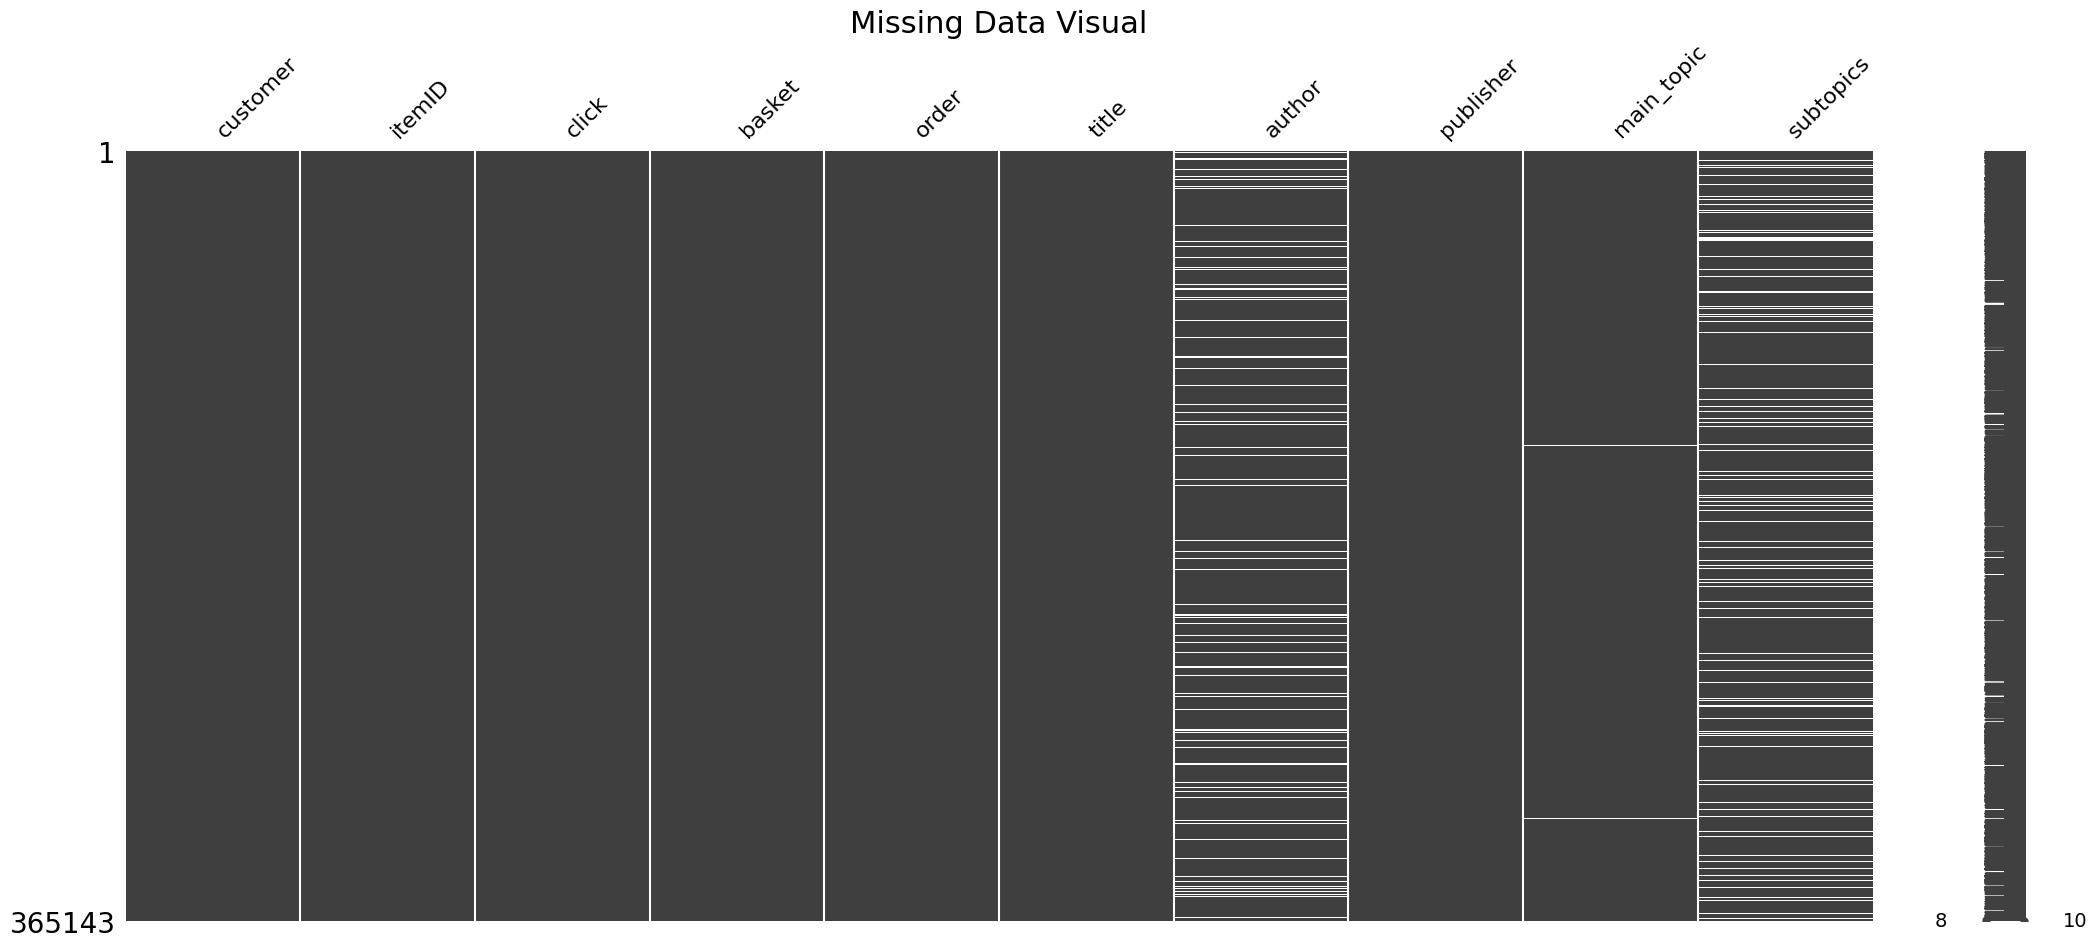

In [38]:
"""
Code used from voinov_lab4
Visualize missing data
"""

import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline 

# External package: conda install missingno 
import missingno as mn

mn.matrix(df)
plt.title("Missing Data Visual",fontsize=22)
plt.show()

In [39]:
print(df.isnull().sum())  # Shows the count of missing values per column

customer          0
itemID            0
click             0
basket            0
order             0
title             0
author        41334
publisher         1
main_topic      895
subtopics     39115
dtype: int64


We can see that no column is missing too much data (365k books vs 41k missing authors). Therefore, it is okay to leave these missing values as they are; imputation is not necessary.

In [40]:
"""
Code adapted from voinov_lab4

Delete any rows that contain missing data
"""

# also delete any row that has any missing value
df_clean = df.dropna().reset_index(drop=True)

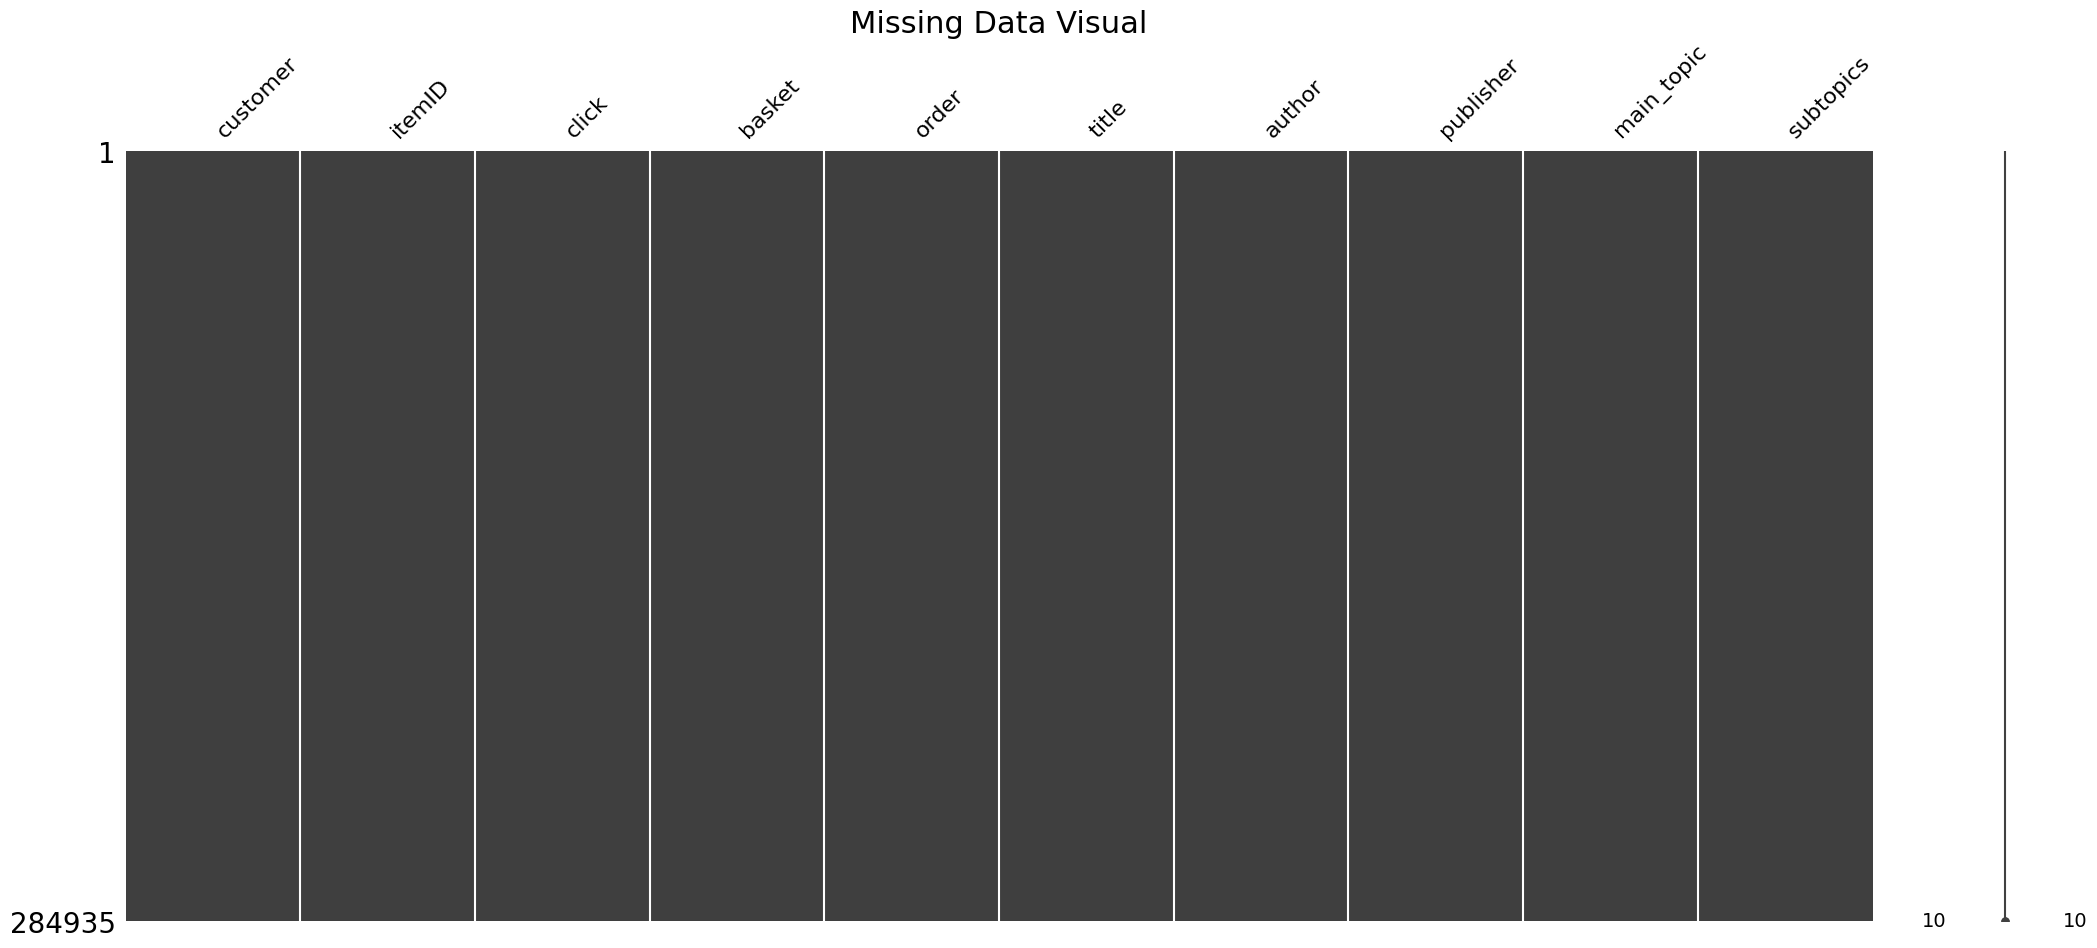

customer    284935
itemID      284935
click       284935
basket      284935
order       284935
dtype: int64

In [41]:
"""
Visualize missing data
"""

import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline 

# External package: conda install missingno 
import missingno as mn

mn.matrix(df_clean)
plt.title("Missing Data Visual",fontsize=22)
plt.show()

df_clean.count().head()

We started with 365143 and ended with 284935 books. This means that deleting every row with a missing value deleted ~20% of the data. This is large but because we have so many data points it's permitable

In [42]:
# export df to csv for simpler loading
df_clean.to_csv("clean_books")

In [ ]:
# For Tiffany, Emmanuel, and Nimai to load cleaned data directly w/ provided cleaned_books.csv file from previous sections
# Run this line then the rest beneath

df_clean = pd.read_csv("clean_books", index_col=0)

Now, we encode and scale


In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Embedding, Concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [6]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 284935 entries, 0 to 284934
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   customer    284935 non-null  int64 
 1   itemID      284935 non-null  int64 
 2   click       284935 non-null  int64 
 3   basket      284935 non-null  int64 
 4   order       284935 non-null  int64 
 5   title       284935 non-null  object
 6   author      284935 non-null  object
 7   publisher   284935 non-null  object
 8   main_topic  284935 non-null  object
 9   subtopics   284935 non-null  object
dtypes: int64(5), object(5)
memory usage: 23.9+ MB


We will use order as our target variable because we want to suggest the top three books that they're most likely to order.

Notice that most variables are categorical It might seem like click and basket could also be categorical because the df.head makes it look like they are binary, but these are numeric count features representing the number of times a customer clicked on or added a book to their basket. Click ranges from 0-118 and basket varies from 0-293.

In [7]:
# Code is adapted from (1)
# This code sets apart the target, categorical, and numerical variables.

from sklearn.preprocessing import LabelEncoder

# ========================================================
target = 'order'  # Predict whether a customer will order a book

# ========================================================
# define variables that should be encoded as categorical (and then OHE)
categorical_headers = ['customer', 'itemID', 'title', 'author', 'publisher',
                       'main_topic', 'subtopics']

# define numeric features (count variables that should be normalized)
numeric_headers = ['click', 'basket']

# get unique values in each feature
for col in categorical_headers:
    print(f'{col} has {len(df_clean[col].unique())} unique values.')

for col in numeric_headers:
    print(f'{col} ranges from {df_clean[col].min()} to {df_clean[col].max()}')

# Convert numeric features to float
df_clean[numeric_headers] = df_clean[numeric_headers].astype(float)

# Convert customer and itemID to strings for string_categorical encodingdf_clean.head()

df_clean['customer'] = df_clean['customer'].astype(str)
df_clean['itemID'] = df_clean['itemID'].astype(str)

customer has 213289 unique values.
itemID has 15963 unique values.
title has 15205 unique values.
author has 6998 unique values.
publisher has 1434 unique values.
main_topic has 572 unique values.
subtopics has 7396 unique values.
click ranges from 0 to 118
basket ranges from 0 to 293


In [8]:
# Code is adapted from (1)
# This code is used to create a dataset in Keras so that it could perform graph operation on all the inputs
batch_size = 64

def create_dataset_from_dataframe(df_input):
    ''' This function will create a tf.dataset using all columns in a df
        The df will have both numeric and categorical headers
    '''
    print('Creating dataset with the following Categorical headers:', categorical_headers)
    print('Creating dataset with the following Numeric headers:', numeric_headers)

    df = df_input.copy()
    labels = df['order']

    # get both categorical and numeric features
    df = {key: value.values[:,np.newaxis] for key, value in df_input[categorical_headers+numeric_headers].items()}

    # create the Dataset here
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    
    # now enable batching and prefetching
    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.prefetch(batch_size)
    
    return ds

ds = create_dataset_from_dataframe(df_clean)

Creating dataset with the following Categorical headers: ['customer', 'itemID', 'title', 'author', 'publisher', 'main_topic', 'subtopics']
Creating dataset with the following Numeric headers: ['click', 'basket']


2025-11-15 19:54:50.702784: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-11-15 19:54:50.703189: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-15 19:54:50.703204: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-11-15 19:54:50.703521: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-15 19:54:50.703543: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Now we will create the feature space for each categorical variable and normalize click and basket.

In [9]:
# Code adapted from (1)
# This code dynamically creates a feature space for each categorical (and numeric) feature. Now we'll be able to measure how close they are to each other.

from tensorflow.keras.utils import FeatureSpace

# Example One: Just lump everything together, and concatenate
feature_space = FeatureSpace(
    features={
        # Categorical feature encoded as string
        "customer":       FeatureSpace.string_categorical(num_oov_indices=0),
        "itemID":         FeatureSpace.string_categorical(num_oov_indices=0),
        "title":          FeatureSpace.string_categorical(num_oov_indices=0),
        "author":         FeatureSpace.string_categorical(num_oov_indices=0),
        "publisher":      FeatureSpace.string_categorical(num_oov_indices=0),
        "main_topic":     FeatureSpace.string_categorical(num_oov_indices=0),
        "subtopics":      FeatureSpace.string_categorical(num_oov_indices=0),

        # Numeric count features (normalized)
        "click":          FeatureSpace.float_normalized(),
        "basket":         FeatureSpace.float_normalized(),


    },
    output_mode="concat", # can also be a dict, processed internally
)

# now that we have specified the preprocessing, let's run it on the data

# create a version of the dataset that can be iterated without labels
# This does NOT duplicate data, it only provides a way to access existing data without the labels
ds_with_no_labels = ds.map(lambda feat, _: feat)  

# The adapt function allows the model to learn one-hot encoding sizes and normalization values
feature_space.adapt(ds_with_no_labels) # inititalize the feature space to this data

# now define a preprocessing operation that returns the processed features
preprocessed_ds = ds.map(lambda feat, labels: (feature_space(feat), labels), 
                                     num_parallel_calls=tf.data.AUTOTUNE)
# run it so that we can use the pre-processed data
preprocessed_ds = preprocessed_ds.prefetch(tf.data.AUTOTUNE)

2025-11-15 19:54:54.866932: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-15 19:54:56.527468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-15 19:54:57.817944: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-15 19:54:59.084911: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-15 19:55:00.238822: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-15 19:55:01.362731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-15 19:55:02.581059: W tensorflow/core/framework/local_rendezvous.cc:404] L

### **1.2 Identifying Cross-Product Features**

Identify groups of features in your data that should be combined into cross-product features. Provide a compelling justification for why these features should be crossed (or, alternatively, why some features should not be crossed)*

Cross product features should be the categorical variables that, when crossed, reveal some 'emergent' relationship. While the two/three variables on their own do provide individual information, the algorithm could learn the new form of information due to their complex relationships could be learned when they're crossed.

Thus, two features that might benefit from crossing are author + publisher. It isn't too far fetched to believe that authors have a favorite / established publisher, so the algorithm may learn some more information from those relations.

Some other features could be publisher + main_topic and publisher + subtopics. It's also not unreasonable to assume that certain publishers lean toward publishing certain topics, and this crossing would tease out some of that realtionship.

Another crossing could involve the author + main_topic and author + subtopics. This crossing would inform the model of the rleation between the author and their commonly explored themes, providing a richer way to measure how similar books might be based on the author.

The title + main_topic could be crossed. This crossing would allow the model to see more complex patterns between book themes and the topics the books present, allowing the model to better match books / cluster them in the embedding space.

Finally, and arguably the most important crossings, are customer + author and customer + main_topic and customer + subtopics. The customer will likely have a perference for authors and topics.

Click and basket shouldn't be crossed because they're numeric features, itemID doesn't make sense to cross with anything other than maybe customer because itemID is an abstraction of a book, and title + publisher wouldn't provide as much information as the ones mentioned (publishers hopefully don't judge a book by its cover but consider the author and the themes and the writing significanlty more).

In [10]:
# Now cross the features
# This code is adapted from (1)

# Repeat what we did in the previous cell but now with crossing
feature_space = FeatureSpace(
    features={
        # Categorical feature encoded as string
        "customer":       FeatureSpace.string_categorical(num_oov_indices=0),
        "itemID":         FeatureSpace.string_categorical(num_oov_indices=0),
        "title":          FeatureSpace.string_categorical(num_oov_indices=0),
        "author":         FeatureSpace.string_categorical(num_oov_indices=0),
        "publisher":      FeatureSpace.string_categorical(num_oov_indices=0),
        "main_topic":     FeatureSpace.string_categorical(num_oov_indices=0),
        "subtopics":      FeatureSpace.string_categorical(num_oov_indices=0),

        # Numeric count features (normalized)
        "click":          FeatureSpace.float_normalized(),
        "basket":         FeatureSpace.float_normalized(),


    },
    # Specify feature cross with a custom crossing dim
    # dim = number of unique values for each category
    crosses=[
        FeatureSpace.cross(
            feature_names=('author','publisher'), # dims: 6998 x 1434
            crossing_dim=6998*1434),
        # new in TF 2.12, three tuples not allowed... 
        FeatureSpace.cross(
            feature_names=('author','customer'), # 6998 x 213289
            crossing_dim=6998*213289),
        FeatureSpace.cross(
            feature_names=('main_topic','customer'), # 572 x 213289
            crossing_dim=572*213289),
        FeatureSpace.cross(
            feature_names=('subtopics','customer'), # 7396 x 213289
            crossing_dim=7396*213289),
        FeatureSpace.cross(
            feature_names=('title','main_topic'), # 15205 x 572
            crossing_dim=15205*572),
        FeatureSpace.cross(
            feature_names=('publisher','main_topic'), # 1434 x 572
            crossing_dim=1434*572),
        FeatureSpace.cross(
            feature_names=('publisher','subtopics'), # 1434 x 7396
            crossing_dim=1434*7396),
        FeatureSpace.cross(
            feature_names=('author','main_topic'), # 6998 x 572
            crossing_dim=6998*572),
        FeatureSpace.cross(
            feature_names=('author','subtopics'), # 6998 x 7396
            crossing_dim=6998*7396),
    ],
    output_mode="concat",
)

# customer has 213289 unique values.
# itemID has 15963 unique values.
# title has 15205 unique values.
# author has 6998 unique values.
# publisher has 1434 unique values.
# main_topic has 572 unique values.
# subtopics has 7396 unique values.
# click ranges from 0 to 118
# basket ranges from 0 to 293

# add explanation of this pre-processing here
ds_with_no_labels = ds.map(lambda x, _: x)
feature_space.adapt(ds_with_no_labels)

# now define a preprocessing operation that returns the processed features
preprocessed_ds = ds.map(lambda feat, labels: (feature_space(feat), labels), 
                                     num_parallel_calls=tf.data.AUTOTUNE)
# run it so that we can use the pre-processed data
preprocessed_ds = preprocessed_ds.prefetch(tf.data.AUTOTUNE)

2025-11-15 19:57:42.614382: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-15 19:57:43.957588: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-15 19:57:45.240315: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-15 19:57:46.450953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-15 19:57:47.752429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-15 19:57:48.999991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-15 19:57:50.220492: W tensorflow/core/framework/local_rendezvous.cc:404] L

### **1.3 Metric(s) to evaluate algorithm's performance**

*Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use, but sometimes it can be. Think critically about an appropriate measure of performance and explain this reasoning.*

Some metrics that we could consider using to evaluate our algorithm's performance are: precision, recall, and F1-Score. However, we want to utilize them for a multi-class classification. However, we should check if our dataset is imbalanced so that way we can consider accuracy as a metric.

In [29]:
# By doing this, we can see how many customers made 0, 1, 2, or 3+ orders
# This is helpful especially for when we split our data into train and test sets
# Below, we grouped the orders into 4 groups: 0 orders, 1 order, 2 orders, and 3+ orders to see if the dataset is imbalanced or not

def group_orders(order_count):
    if order_count == 0:
        return 0
    elif order_count == 1:
        return 1
    elif order_count == 2:
        return 2
    else:
        return 3  # 3+ orders grouped together

df_clean['order_grouped'] = df_clean['order'].apply(group_orders)

order_dist = df_clean['order_grouped'].value_counts().sort_index()
print("\nGrouped Order Distribution:")
for group, count in order_dist.items():
    print(f"Orders ({group}): {count}")
    
# Conversion rates for grouped orders
total_customers = len(df_clean)
print("\nGrouped Order Percentages:")
for group in range(4):
    count = order_dist.get(group, 0)
    conversion_rate = (count / total_customers) * 100
    print(f"Percentages of order group ({group}): {conversion_rate:.2f}%")
    


Grouped Order Distribution:
Orders (0): 270236
Orders (1): 14469
Orders (2): 185
Orders (3): 45

Grouped Order Percentages:
Percentages of order group (0): 94.84%
Percentages of order group (1): 5.08%
Percentages of order group (2): 0.06%
Percentages of order group (3): 0.02%


**Why Accuracy is not appropriate for our problem**

Because our dataset is heavily imbalanced with the majority of interactions resulting in no order-accuracy becomes a misleading performance metric. A model could achieve a deceptively high accuracy simply by predicting the majority class (“no order”) for almost every case. Such a model would appear to perform well numerically while failing entirely at the actual business objective, which is identifying customers who will order and recommending products they are likely to buy.

In imbalanced classification settings, accuracy essentially rewards doing nothing: it ignores the cost of missing rare but valuable positive cases, and it hides the model’s inability to detect them. Therefore, relying on accuracy would overestimate the effectiveness of our system and would not reflect meaningful predictive performance.

**Now, for our reasons why we chose precision, recall, and F1-Score:**
- **Precision**: This metric can measure the quality of our recommendations, especially in a business case. One question that a business could ask: "Out of the three books we recommend to a customer, how many will they actually purchase?" With precision, it can measure our model's ability to avoid false positives. In this case, it means that a false positive is recommending a book the customer won't order, which wastes an opportunity to show them something they'd actually want based on their interests (authors they've read, topics, etc.) What we want to achieve from this metric is to at least have 1 out of the 3 books ordered. Anything that results in 0 out of 3 is considered a failure.


- **Recall**: This metric can capture the opportunity cost. Low recall in this case would mean that we're missing sales by failing to recommend books customers would have bought. They might leave and find books elsewhere. A question a business could ask: "Of all books a customer would order, how many appear in our top 3 recommendations?" This metric would measure our model's ability to avoid false negatives (not false positives like Precision). False negatives in our case would mean failing to recommend a book the customer would have ordered, which would be a missed revenue opportunity (from a business perspective, we want to make as much money as we can by recommending books to customers).


- **F1-Score**: We cannot forget about F1-Score if we are already considering Precision and Recall as some of ours. By having F1-Score, we can balance precision and recall into a single metric. We cannot use Precision and Recall alone for this dataset, especially with how maximizing precision would only recommend obvious bestsellers, in return hurting the recall metric, but maximizing Recall would mean we'd recommend many books, which would hurt precision in return. The F1-Score can bring balance to an imbalanced dataset such as what we are working with now. By doing so, we are ensuring that we don't sacrifice one metric for the other, hence why we chose F1-Score as one of the metrics.

### **1.4 Data Splitting Method**
*Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate and use this method during training. Argue why your splitting method is a realistic mirroring of how an algorithm would be used in practice.*

We use a stratified train-test split rather than cross-validation. Because our dataset is large (280,000+ observations), a single well-balanced split is sufficient to estimate out-of-sample performance reliably. Stratification ensures that the distribution of our target classes is preserved in both the training and testing sets, preventing class imbalance from unintentionally biasing model evaluation. Cross-validation is more appropriate when datasets are small and model performance is highly sensitive to sampling fluctuations. In our case, however, 10-fold cross-validation would require training 10 separate models—significantly increasing computational cost without providing a meaningful improvement in estimation accuracy, given the size and stability of our dataset.

A stratified train–test split also mirrors how the model would be used in practice. In real deployment settings, an organization typically trains one final model on all available historical data and then evaluates it once on a held-out set before deployment. Businesses rarely retrain the same model 10 times on different folds unless hyperparameter tuning requires it. Therefore, our approach reflects a realistic production workflow: train a single model, validate it once on a representative hold-out sample, and deploy.

In [ ]:
# Adapted from Copilot to stratify based on grouped order counts
print("Grouped order distribution:")
print(df_clean['order_grouped'].value_counts())

# Now stratify on grouped version
train_val_df, test_df = train_test_split(
    df_clean, 
    test_size=0.2, 
    random_state=42, 
    stratify=df_clean['order_grouped']
)

train_df, val_df = train_test_split(
    train_val_df, 
    test_size=0.2, 
    random_state=42, 
    stratify=train_val_df['order_grouped']
)

print("\nTrain shape:", train_df.shape) # Should be 64% of data
print("Validation shape:", val_df.shape) # Should be 16% of data
print("Test shape:", test_df.shape) # Should be 20% of data


Grouped order distribution:
order_grouped
0    270236
1     14469
2       185
3        45
Name: count, dtype: int64

Train shape: (182358, 11)
Validation shape: (45590, 11)
Test shape: (56987, 11)


It should be prepared to be modeled now that we have split our dataset!